In [164]:
import pandas as pd
# -*- coding: utf-8 -*-
import click
import logging
from pathlib import Path
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
import itertools
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [165]:
import array
import random
import json

import numpy

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
from scoop import futures
import pandas as pd

In [166]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1) 

In [167]:
data = pd.read_csv('/Users/b1017579/Documents/Projects/Fish/fish-stock-optimiser/data/raw/fish0.01.csv')
# data = data[data.spp !="brill"]
data.head()

,Unnamed: 0,spp,k1,k2,kobe,safety,yield,yieldAav
0,1,turbot,1.196676,0.918369,0.76,0.887833,0.877494,0.077496
1,2,turbot,0.251354,0.567360,0.04,0.578210,0.884512,0.043398
2,3,turbot,0.593866,1.079009,0.08,0.605767,0.980269,0.106282
3,4,turbot,0.057831,1.312772,0.08,0.592171,1.011694,0.103961
4,5,turbot,0.989171,0.581586,0.76,0.888670,0.697099,0.029746


In [168]:
by_fish = data.copy()
# single_optimiser['reward'] = single_optimiser.safety + single_optimiser['kobe.n'] + single_optimiser.yield
# single_optimiser['reward'] = data[['safety','kobe.n','yield','yieldAav']].sum(axis=1)
by_fish['reward'] = 1*data['safety']+1*data['kobe']+1*data['yield']+1*data['yieldAav']
by_fish = by_fish[['spp', 'k1','k2','kobe','yield','reward']]
by_fish['reward'] = by_fish['reward'].apply(lambda x: x*-1)
by_fish.head()

,spp,k1,k2,kobe,yield,reward
0,turbot,1.196676,0.918369,0.76,0.877494,-2.602823
1,turbot,0.251354,0.567360,0.04,0.884512,-1.546120
2,turbot,0.593866,1.079009,0.08,0.980269,-1.772318
3,turbot,0.057831,1.312772,0.08,1.011694,-1.787826
4,turbot,0.989171,0.581586,0.76,0.697099,-2.375515


In [169]:
def fit_model(m, reward):
#     options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
#     max_bound = 1 * np.ones(2)
#     min_bound = - max_bound
#     bounds = (min_bound, max_bound)

    X = np.array(m[['k1','k2']])
    y = np.array(m[reward])
#     clf = MLPRegressor(hidden_layer_sizes=(50, 30, 50), activation='relu', solver='adam', alpha=1,
#                                         batch_size='auto', learning_rate='constant', learning_rate_init=0.05, power_t=0.5,
#                                         max_iter=10000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False,
#                                         momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    svr_model = SVR(gamma='scale', C=1.0, epsilon=0.1)
    param_grid={
        'kernel': ['rbf'],
        
#         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#         'epsilon': [0.01, 0.1, 0.2, 0.5, 0.7, 1.0, 10],
#         'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 100]
    }
        
    clf = GridSearchCV(estimator=svr_model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=True, scoring='neg_median_absolute_error', return_train_score=True)
    clf.fit(X, y)
    
    return clf


In [170]:
def predictor_rewards(data):
    clf_safety = fit_model(data, 'safety')
    clf_kobe = fit_model(data, 'kobe')
    clf_yield = fit_model(data, 'yield')
    clf_yieldAav = fit_model(data, 'yieldAav')
    return (clf_safety, clf_kobe, clf_yield, clf_yieldAav)

In [171]:
def maximise_function(individual, clf_safety, clf_kobe, clf_yield, clf_yieldAav):
    individual = np.array(individual).reshape(1, -1)
    safety = float(clf_safety.predict(individual))
    kobe = float(clf_kobe.predict(individual))
    yield_val = float(clf_yield.predict(individual))
    yieldAav = float(clf_yieldAav.predict(individual))
    
#     return (safety, kobe, yield_val, yieldAav)
    return (safety, yield_val)

In [172]:
# creator.create("FitnessMin", base.Fitness, weights=(1.0, 1.0, 1.0, 1.0))
creator.create("FitnessMin", base.Fitness, weights=(1.0, 1.0))

creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = 0.0, 1.5

# Functions zdt4 has bounds x1 = [0, 1], xn = [-5, 5], with n = 2, ..., 10
# BOUND_LOW, BOUND_UP = [0.0] + [-5.0]*9, [1.0] + [5.0]*9

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10
NDIM = 2

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox.register("map_distributed", futures.map)

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", maximise_function)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)


def main(clf_safety, clf_kobe, clf_yield, clf_yieldAav, seed=None, initial_guess = None):
    # random.seed(seed)

    toolbox.register("evaluate", maximise_function, clf_safety = clf_safety, clf_kobe = clf_kobe, clf_yield = clf_yield, clf_yieldAav = clf_yieldAav)
    
    NGEN = 100
    MU = 400
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    pop = toolbox.population(n=MU)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map_distributed(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
#         print("-- Generation %i --" % gen)
        print(" {}".format(gen), end='')
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)

            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map_distributed(toolbox.evaluate, invalid_ind)

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

#         print("  Evaluated %i individuals" % len(invalid_ind))


        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)

        best_ind = tools.selBest(pop, 1)[0]

#         print("Best individual is %s, %s" %
#           (np.rint(best_ind), best_ind.fitness.values))

        front = numpy.array(
            [ind.fitness.values + tuple(ind) for ind in pop])

        # np.savetxt('{}/src/models/optimisation_algorithms/genetic_algorithms/pareto_front/k_meansdata/pareto_front_{}.csv'.format(project_dir, gen), front, delimiter=",")
        np.savetxt('/Users/b1017579/Documents/Projects/Fish/fish-stock-optimiser/models/results/nsga_ii/first_run.csv'.format(), front, delimiter=",")


#         Plotting pareto front
        
        fig = plt.figure(1)

        columns = 2
        rows = 1

        fig.add_subplot(rows, columns, 1)
        plt.scatter(front[:, 0], front[:, 1], c="b")

        fig.add_subplot(rows, columns, 2)
        plt.scatter(front[:, 1], front[:, 2], c="b")

        # # plt.savefig('{}/src/models/optimisation_algorithms/genetic_algorithms/pareto_front/k_means/images/pareto_front_{}.png'.format(project_dir, gen))
        # plt.savefig('{}/optimisation/algorithms/pareto_front/nsga_ii/images/pareto_front_{}.png'.format(project_dir, gen))
        
        plt.close()

        fig = plt.figure(1)
        ax = Axes3D(fig)
        ax.scatter(front[:, 0], front[:, 1], front[:, 2], c='red')

        ax.axis("tight")
#         fig.savefig('{}/optimisation/algorithms/pareto_front/nsga_ii/images/pareto_front_3D_{}.png'.format(project_dir, gen))
        # fig.savefig('{}/src/models/optimisation_algorithms/genetic_algorithms/pareto_front/k_means/images/pareto_front_3D_{}.png'.format(project_dir, gen))
        plt.close()

    # print("Final population hypervolume is %f" %
    #   hypervolume(pop, [11.0, 11.0]))

#     return pop, logbook
    return front

/Users/b1017579/.pyenv/versions/3.6.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/b1017579/.pyenv/versions/3.6.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [173]:
def optimise_each_stock(dat):
    safety, kobe, yield_val, yieldAav = predictor_rewards(dat)
    front = main(safety, kobe, yield_val, yieldAav)
    return front

Yield and Kobe


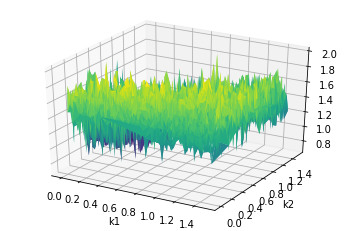

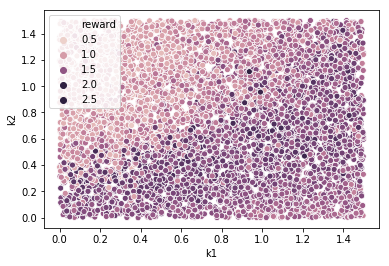

In [174]:
yield_kobe = data.copy()
yield_kobe['reward'] = data['kobe']+data['yield']

def plot_total_stocks(yield_kobe):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    print("Yield and Kobe")
    ax.plot_trisurf(yield_kobe['k1'], yield_kobe['k2'], yield_kobe.reward, cmap=plt.cm.viridis, linewidth=0.2)
    plt.xlabel("k1")
    plt.ylabel("k2")

    plt.show()

    sns.scatterplot(yield_kobe['k1'], yield_kobe['k2'], hue = yield_kobe.reward)
    plt.xlabel("k1")
    plt.ylabel("k2")
    
plot_total_stocks(yield_kobe)

In [175]:
all_stocks = optimise_each_stock(data)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                    	avg                    	max                    
0  	400  	[0.10104393 0.09127066]	[0.55966905 0.60673849]	[0.71871395 0.93226654]	[0.87881774 1.03392445]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99

Yield and Kobe


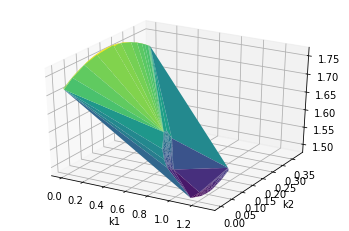

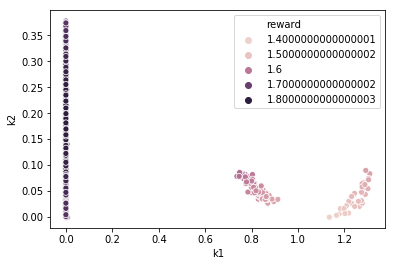

In [182]:
all_stocks_result = pd.DataFrame(all_stocks)
# all_stocks_result.columns = ['safety', 'kobe', 'yield_val', 'yieldAav', 'k1', 'k2']
all_stocks_result.columns = ['safety', 'yield_val', 'k1', 'k2']
all_stocks_result['reward'] = all_stocks_result['yield_val'] + all_stocks_result['safety']
plot_total_stocks(all_stocks_result)

In [183]:
def pareto_plot(dat, x, y):
    fig = plt.figure()
    plt.scatter(dat[x], dat[y], cmap=plt.cm.viridis, linewidth=0.2)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

# print(all_stocks_result[(all_stocks_result.yield_val > 0.8)].sort_values(by='kobe', ascending=False))



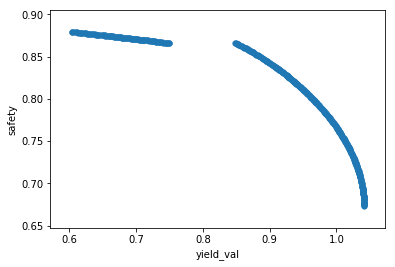

In [185]:
# two_noise_results = all_stocks_result.copy()
# two_noise_results.to_csv('/Users/b1017579/Documents/Projects/Fish/fish-stock-optimiser/models/results/nsga_ii/pareto_fronts/two_noise_results.csv')
pareto_plot(all_stocks_result, 'yield_val', 'safety')

In [161]:
two_noise_results.head()
two_noise_results['noise'] = 0.2

In [162]:
all_stocks_result['noise'] = 0.01

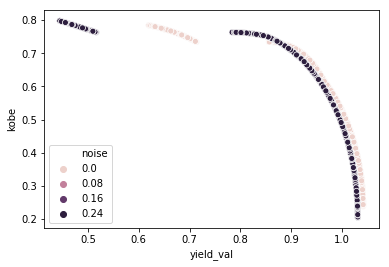

In [163]:
both_results = pd.concat([all_stocks_result, two_noise_results])
fig = plt.figure()
sns.scatterplot(data = both_results, x='yield_val', y='kobe', hue='noise')
# plt.xlabel(x)
# plt.ylabel(y)
plt.show()

In [63]:
def threeD_plotter(dat):
    for i in range(4):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_trisurf(dat['k1'], dat['k2'], dat.iloc[:,i], cmap=plt.cm.viridis, linewidth=0.2)
        ax.set_xlabel("k1")
        ax.set_ylabel("k2")
        ax.set_zlabel(dat.columns[i])
        ax.dist = 13
        plt.show()

In [64]:
def twoD_plotter(dat):
    for i in range(4):
        fig = plt.figure()
        sns.scatterplot(dat['k1'], dat['k2'], hue = dat.iloc[:,i])
        plt.xlabel("k1")
        plt.ylabel("k2")

        plt.show()
        plt.close()

## Each Fish

In [65]:
each_stock_results = data.groupby('spp').apply(optimise_each_stock)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                      	avg                    	max                    
0  	400  	[0.33168156 0.31225118]	[-0.10296085  0.12043815]	[0.24560393 0.9752792 ]	[0.90573822 1.31979532]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                      	avg                    	max                    
0  	400  	[0.32722605 0.30268472]	[-0.10138744  0.13429204]	[0.24763694 0.97857596]	[0.9033058  1.31938485]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                      	avg                    	max                    
0  	400  	[0.38328859 0.09769439]	[-0.05455619  0.67764138]	[0.42087075 0.96058504]	[1.04660702 1.08974573]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                    	avg                    	max                    
0  	400  	[0.14524447 0.32909982]	[0.11983145 0.04967486]	[0.56129619 0.48554896]	[0.744829   1.02667836]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                      	avg                    	max                    
0  	400  	[0.28418189 0.21612191]	[-0.10068085  0.14654862]	[0.39117136 0.78008026]	[0.81165795 1.03510505]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99

In [66]:
for dat, name in zip(each_stock_results, each_stock_results.axes[0]):
    print(name)
    df = pd.DataFrame(dat)
    df.columns = ['safety', 'kobe', 'yield_val', 'yieldAav', 'k1', 'k2']
    threeD_plotter(df)

pollack


ValueError: Length mismatch: Expected axis has 4 elements, new values have 6 elements

In [67]:
for dat, name in zip(each_stock_results, each_stock_results.axes[0]):
    print(name)
    df = pd.DataFrame(dat)
    df.columns = ['safety', 'kobe', 'yield_val', 'yieldAav', 'k1', 'k2']
    twoD_plotter(df)

pollack


ValueError: Length mismatch: Expected axis has 4 elements, new values have 6 elements

## Each Stock - Yield and Kobe Optimisation

In [68]:
def threeD_plotter_reward(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(dat['k1'], dat['k2'], dat.reward, cmap=plt.cm.viridis, linewidth=0.2)
    plt.xlabel("k1")
    plt.ylabel("k2")
    ax.set_zlabel("Yield and Kobe")
    ax.dist = 13
    plt.show()

In [69]:
for dat, name in zip(each_stock_results, each_stock_results.axes[0]):
    print(name)
    df = pd.DataFrame(dat)
    df.columns = ['safety', 'kobe', 'yield_val', 'yieldAav', 'k1', 'k2']
    df['reward'] = df.kobe+df.yield_val
    threeD_plotter_reward(df)

pollack


ValueError: Length mismatch: Expected axis has 4 elements, new values have 6 elements

In [70]:
def twoD_plot_reward(dat):
    fig = plt.figure()
    sns.scatterplot(dat['k1'], dat['k2'], hue = dat.reward)
    plt.xlabel("k1")
    plt.ylabel("k2")

    plt.show()
    plt.close()

In [71]:
for dat, name in zip(each_stock_results, each_stock_results.axes[0]):
    print(name)
    df = pd.DataFrame(dat)
    df.columns = ['safety', 'kobe', 'yield_val', 'yieldAav', 'k1', 'k2']
    df['reward'] = df.kobe+df.yield_val

    twoD_plot_reward(df)

pollack


ValueError: Length mismatch: Expected axis has 4 elements, new values have 6 elements

## Each Stock, Pareto Front: Kobe and Yield

In [72]:
each_stock_kobe = data.groupby('spp').apply(optimise_each_stock)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                      	avg                    	max                    
0  	400  	[0.33021034 0.32532152]	[-0.10263433  0.08528677]	[0.25249821 0.94824802]	[0.90772178 1.32063459]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                      	avg                    	max                    
0  	400  	[0.34897172 0.30850394]	[-0.10297795  0.08556413]	[0.25329045 0.94606008]	[0.9091549  1.32039593]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                      	avg                    	max                    
0  	400  	[0.39772475 0.09513999]	[-0.05654807  0.67561691]	[0.4526162  0.95984997]	[1.04115251 1.08969004]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                    	avg                    	max                    
0  	400  	[0.12769095 0.32123367]	[0.11890772 0.05375016]	[0.575638   0.47641894]	[0.74443344 1.02721064]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


gen	evals	std                    	min                      	avg                    	max                    
0  	400  	[0.28791349 0.21436424]	[-0.1010596   0.14387655]	[0.36489615 0.76532153]	[0.79692338 1.03282321]
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99

pollack


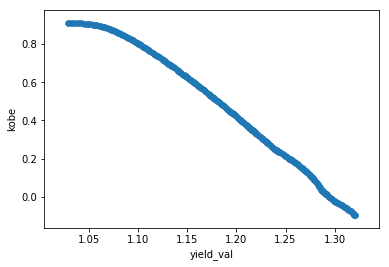

ray


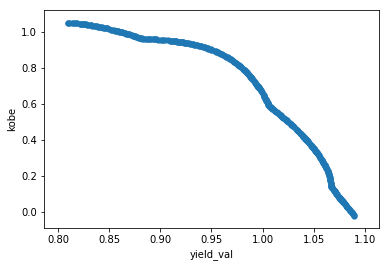

sprat


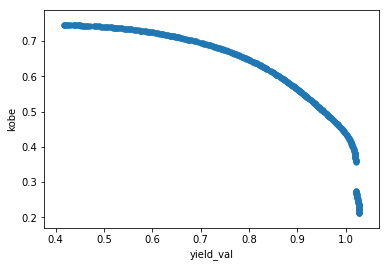

turbot


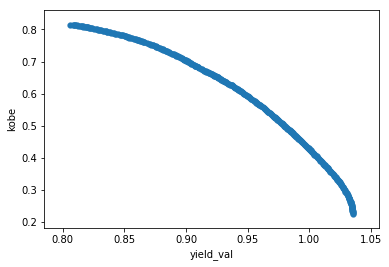

In [73]:
each_stock_kobe

for dat, name in zip(each_stock_kobe, each_stock_kobe.axes[0]):
    print(name)
    df = pd.DataFrame(dat)
    df.columns = ['kobe', 'yield_val', 'k1', 'k2']
    df['reward'] = df.kobe+df.yield_val

    fig = plt.figure()
    # ax = fig.gca(projection='3d')
    plt.scatter(df['yield_val'], df['kobe'], cmap=plt.cm.viridis, linewidth=0.2)
    plt.xlabel("yield_val")
    plt.ylabel("kobe")
    # ax.set_zlabel('yield_val')
    # ax.dist = 13
    plt.show()